In [13]:
import torch
import netCDF4 as nc
import numpy as np
import torch
from time import perf_counter
import os
from unbalancedsinkhorn import DebiasedUOT

import matplotlib.pyplot as plt


In [ ]:
# You may be required to install nedCDF4 pandas python package.
# Uncomment the following line to install it if needed:
# ! pip install netCDF4 pandas


# Initialise parameters and hyperparameters

In [ ]:
# Set epsilon and rho
# Epsilon is set by the grid resolution, hence assuming you have set the grid to be
# O(1) of size (N) epsilon = 1/sqrt(N).
# For rectanglar grids with lengths (L1, L2) and number of points (n1, n2), a suitable approximation 
# is epsilon = min(L1, L2)/(sqrt(n1*n2)).
eps = 0.005

# Rho is set by the user and is related to the reach parameter. Recall this relation is strong for the tv regularsation than Kl.
# Call rho = sqrt(2*reach) and the reach is in units of distance beyound which there is a weaker association of features.
# If you have removed dimension from the grid, then rho should also be dimensionless.
rho = 1

# Pick type of regularisation,
# If the data is balanced yiou can caluate 'balanced' version which does not allow mass to be destroyed.
# Otherwsie is should be 'kl' or 'tv'.
aprox_type = 'kl' 

# DATA
# Data for the simple idealised geosmetric cases is avaliable from 
# https://projects.ral.ucar.edu/icp/Data/NewGeom/test_fields.zip

# Once downloaded and unzipped, provide the path to the data.
path_to_data = '/home/jacob/PhD_jobs/ICP_Cases/MescoVict_cases/' # this will need changing

# Choose idealised cases from any of those avaliable in the data folder.
case = ('C1', 'C6')

# ToDO: I think if a devicce is visible then it is stil using this by default.
if torch.cuda.is_available():
    cuda = 0
else:
    cuda = None # Default 'cpu' device


## Data scaling

ICP real cases, on true regular lon lat, it had size 501, 601.  Then I ignored the true lon lat, and createed a mesh grid 501, 601 in [0,1] x[0,1]. If your grid has length scale [0, L1 km] and [0, L2 km], then rescale to order one by dividing by L = min(L1, L2). 




    (lon - lon_min) / min((lon_max - lon_min), (lat_max - lat_min))
    (lat - lat_min) / min((lon_max - lon_min), (lat_max - lat_min))


##### MesoVICT - Grid
Of shape (N,2) roughly fitted on a regular grid, though didn't fill thee regular. So I added zero points to the non-filled areas of the density, so that it fitted a regular grid.

In [ ]:
# An example of creating a regular mesh
X, Y = torch.meshgrid(
    torch.linspace(0, 1, 501),
    torch.linspace(0, 2, 601),
    indexing='ij'
)

input = torch.stack((X, Y), dim=-1)

#### Density scaling
Pick an out-of-sample ideally. This could be climatogical, or historical average.
Scale  Observation and Forecast by the same number.
Leave out dry days.

    -ICP: I took in sample average
    -MesoVICT: I took the eobservation average
    -Real ICP: Observation average

In [3]:

def load_test_fields_bias_scaling(fieldx: str, fieldy: str, L=200, dtype=torch.float64, path_to_data='',cases_scale=1873.5):

    # Load data
    X_i = nc.Dataset(
        path_to_data + str(fieldx) + ".nc"
    )

    # For the 10 grid point increment cases we luse C1 rolled over 10 grid points.
    if type(fieldy) == int:
        # Repeat the x field then shift it through 'roll' later
        Y_j = nc.Dataset(
        path_to_data + str(fieldx) + ".nc"
    )
    else:
        Y_j = nc.Dataset(
            path_to_data + str(fieldy) + ".nc"
        )

    # Extract scaled fields
    X_coordinates = torch.stack(
        torch.meshgrid(
            torch.tensor(X_i["x"][:].__array__(), dtype=dtype) / L,
            torch.tensor(X_i["y"][:].__array__(), dtype=dtype) / L,
            indexing="xy",
        ),
        axis=2,
    )
    X_precipitation = X_i["var2d"][:].__array__()
    Y_coordinates = torch.stack(
        torch.meshgrid(
            torch.tensor(Y_j["x"][:].__array__(), dtype=dtype) / L,
            torch.tensor(Y_j["y"][:].__array__(), dtype=dtype) / L,
            indexing="xy",
        ),
        axis=2,
    )
    Y_precipitation = Y_j["var2d"][:].__array__()

    mass_x, mass_y = np.sum(X_precipitation), np.sum(Y_precipitation)

    X_precipitation /= cases_scale
    Y_precipitation /= cases_scale

    if type(fieldy) == int:
        return (
            X_coordinates,
            X_precipitation,
            Y_coordinates,
            np.roll(Y_precipitation, fieldy, axis=1),
            mass_x,
            mass_y,
        )
    else:
        return (
            X_coordinates,
            X_precipitation,
            Y_coordinates,
            Y_precipitation,
            mass_x,
            mass_y,
        )


## Basic usage

You can preprocesss your data however you want and then need to provide a numpy or pytorch array for the grid, X, (also the Y if the forecast and obsrvtion have differt meshes). This should be scaled down to be O(1), long thin domains may have stability issues, so use epsilon annealing. 

X and Y are  assumed  to be given in cartesian coordiates so that the usual Euclideean cost is appropirate for finding distances between points ($sqrt{x^2 + y^2}$). If the points lie on regular grids, i.e. have shape (n1, n2, 2) then you may provide the data in this format and tensorisation will be used as a speed up. 

Otherwise, for non-regulara grids, provid the data in shape (N, 2). 

Associated to the grid, and in the similar shape ((n1,n2,1) or (N,1)) also provide  two densities for the forecast and observation. Below these are called alpha, and whlist they do not need to sum to one, they again should be scaled to b O(1) if possible.

In [5]:
X, alpha, Y, beta, mass_x, mass_y = load_test_fields_bias_scaling(
        case[0], case[1], path_to_data=path_to_data
    )

ot_class = DebiasedUOT(cuda_device=cuda, pykeops=True)
ot_class.parameters(epsilon=eps, rho=rho)
ot_class.densities(
    target_points=X, source_points=Y, target_density=alpha, source_density=beta
)

tic = perf_counter()
f_update, g_update, isup = ot_class.sinkhorn_algorithm(
    sinkhorn_steps=5000,
    tol=1e-12,
    verbose=False,
    aprox=aprox_type,
    epsilon_annealing=True
)
toc = perf_counter()
print(f'Ran in {toc-tic} ns')

Tensorising from given mesh, assuming ij index and assuming mesh is regular
Final error at esp=0.00500735267996788, err=3.7583317036293806e-07, its=1057/1057
Convergence in f, g updates below 1e-12 in 2080 iterations
Ran in 163.18251381799928 ns


In [9]:
s, p = ot_class.sinkhorn_divergence(
force_type="pykeops", return_type="breakdown"
)
# d = ot_class.dual_cost(force_type="pykeops")

Tensorising from given mesh, assuming ij index and assuming mesh is regular
Tensorising from given mesh, assuming ij index and assuming mesh is regular
Convergence in f, g updates below 1e-12 in 1086 iterations
f debias tensor(False, device='cuda:0') tensor(False, device='cuda:0')
Convergence in f, g updates below 1e-12 in 1086 iterations
g debias? tensor(False, device='cuda:0') tensor(False, device='cuda:0')
[KeOps] Generating code for formula Sum_Reduction(((((Exp(((Var(1,1,0)+Var(0,1,1))-(1/2*Var(7,1,2))*((Var(2,2,0)-Var(3,2,1))|(Var(2,2,0)-Var(3,2,1))))/Var(4,1,2))*Var(5,1,0))*Var(6,1,1))*1/2)*Var(7,1,2))*((Var(2,2,0)-Var(3,2,1))|(Var(2,2,0)-Var(3,2,1))),1) ... OK
[KeOps] Generating code for formula Sum_Reduction(((Exp(((Var(1,1,0)+Var(0,1,1))-(1/2*Var(7,1,2))*((Var(2,2,0)-Var(3,2,1))|(Var(2,2,0)-Var(3,2,1))))/Var(4,1,2))*Var(5,1,0))*Var(6,1,1))*(((Var(1,1,0)+Var(0,1,1))-(1/2*Var(7,1,2))*((Var(2,2,0)-Var(3,2,1))|(Var(2,2,0)-Var(3,2,1))))/Var(4,1,2)-1)+Var(5,1,0)*Var(6,1,1),1) ... O

We now have access to the debiased, p and constituent terms;

In [10]:
print('Debiased cost, ', s.cpu().item())
print('Cost breakdown,', "p1",  p[0].cpu().item(),
            "p2", p[1].cpu().item(),
            "p3", p[2].cpu().item(),
            "p4", p[3].cpu().item()
            )

Debiased cost,  tensor(0.135921240281493, device='cuda:0', dtype=torch.float64)
Cost breakdown, p1 0.015587849108591725 p2 0.0029374707414535953 p3 0.051339366591215574 p4 0.07196039745232385


# Diagnostics

### Barycentres
We strat by calculating the transport vectors, through the barycentric projection, thencan caluate diagnostic quantites and plot diagrams. Much of this code is avaliable in the resultss section plotting_utils script.

In [11]:
temp_dict = {}
V0 = ot_class.barycentre_map_of_points("target").cpu()
V1 = ot_class.barycentre_map_of_points("source").cpu()
u0 = ot_class.debias_f.barycentre_map_of_points("target").cpu()
u1 = ot_class.debias_g.barycentre_map_of_points("source").cpu()

# -------------------------------- FORWARD -------------------------------- 
v0 = -V0

# Calculate x and y average direction of the transport vectors.
C = torch.nanmean(v0[:,0])
S = torch.nanmean(v0[:,1])

# Convert for circular mean average then back to degrees
direction, mag = torch.arctan2(S, C), torch.sqrt(C**2 + S**2)
temp_dict["forward_mean_mag_p"] = mag.cpu().item()
temp_dict["forward_mean_dir_p"] = direction.cpu().item()

# Calculate median average
mag = v0.norm(dim=1)
direction = torch.rad2deg(torch.arctan2(v0[:, 1], v0[:, 0]))

temp_dict["forward_median_mag_p"] = torch.nanmedian(mag).cpu().item()
temp_dict["forward_median_dir_p"] = torch.nanmedian(direction).cpu().item()

# Define the debiased vector: v0 = -(V0 - u0)
v0_bias = -(V0 - u0)

# Calculate C and S
C = torch.nanmean(v0[:,0])
S = torch.nanmean(v0[:,1])

# Convert for circular mean average then back to degrees
direction, mag = torch.arctan2(S, C), torch.sqrt(C**2 + S**2)
temp_dict["forward_mean_mag_se"] = mag.cpu().item()
temp_dict["forward_mean_dir_se"] = direction.cpu().item()

mag = v0_bias.norm(dim=1)
direction = torch.rad2deg(torch.arctan2(v0_bias[:, 1], v0_bias[:, 0]))

temp_dict["forward_median_mag_se"] = torch.nanmedian(mag).cpu().item()
temp_dict["forward_median_dir_se"] = torch.nanmedian(direction).cpu().item()

# -------------------------------- REVERSE --------------------------------
v0 = -V1

# Calculate C and S
C = torch.nanmean(v0[:,0])
S = torch.nanmean(v0[:,1])

# Convert for circular mean average then back to degrees
direction, mag = torch.arctan2(S, C), torch.sqrt(C**2 + S**2)
temp_dict["inverse_mean_mag_p"] = mag.cpu().item()
temp_dict["inverse_mean_dir_p"] = direction.cpu().item()

mag = v0.norm(dim=1)
direction = torch.rad2deg(torch.arctan2(v0[:, 1], v0[:, 0]))

temp_dict["inverse_median_mag_p"] = torch.nanmedian(mag).cpu().item()
temp_dict["inverse_median_dir_p"] = torch.nanmedian(direction).cpu().item()

# Define the debiased vector:
v0_debias = -(V1 - u1)

# Calculate C and S
C = torch.nanmean(v0[:,0])
S = torch.nanmean(v0[:,1])

# Convert for circular mean average then back to degrees
direction, mag = torch.arctan2(S, C), torch.sqrt(C**2 + S**2)
temp_dict["inverse_mean_mag_se"] = mag.cpu().item()
temp_dict["inverse_mean_dir_se"] = direction.cpu().item()

mag = v0_debias.norm(dim=1)
direction = torch.rad2deg(torch.arctan2(v0_debias[:, 1], v0_debias[:, 0]))

temp_dict["inverse_median_mag_se"] = torch.nanmedian(mag).cpu().item()
temp_dict["inverse_median_dir_se"] = torch.nanmedian(direction).cpu().item()

[KeOps] Generating code for formula Sum_Reduction(((Exp(((Var(1,1,0)+Var(0,1,1))-(1/2*Var(7,1,2))*((Var(2,2,0)-Var(3,2,1))|(Var(2,2,0)-Var(3,2,1))))/Var(4,1,2))*Var(5,1,0))*Var(6,1,1))*Var(8,2,1),0) ... OK


In [15]:
temp_dict

{'forward_mean_mag_p': 9.598704604284392e-17,
 'forward_mean_dir_p': 1.7075246831283926,
 'forward_median_mag_p': 0.13693931546645394,
 'forward_median_dir_p': 1.1958313551124335e-12,
 'forward_mean_mag_se': 9.598704604284392e-17,
 'forward_mean_dir_se': 1.7075246831283926,
 'forward_median_mag_se': 0.16261479851419794,
 'forward_median_dir_se': 4.619491126269943e-11,
 'inverse_mean_mag_p': 1.3231918581351392e-17,
 'inverse_mean_dir_p': 2.2167927516816683,
 'inverse_median_mag_p': 0.16261982123899735,
 'inverse_median_dir_p': -67.80416341958872,
 'inverse_mean_mag_se': 1.3231918581351392e-17,
 'inverse_mean_dir_se': 2.2167927516816683,
 'inverse_median_mag_se': 0.15958631265502699,
 'inverse_median_dir_se': -88.21174929410847}

temp_dict contains the ATD aand ATM in both forward and reverse direction, and whilst taking the mean or mdian average. We may also be interested in its overall spread;

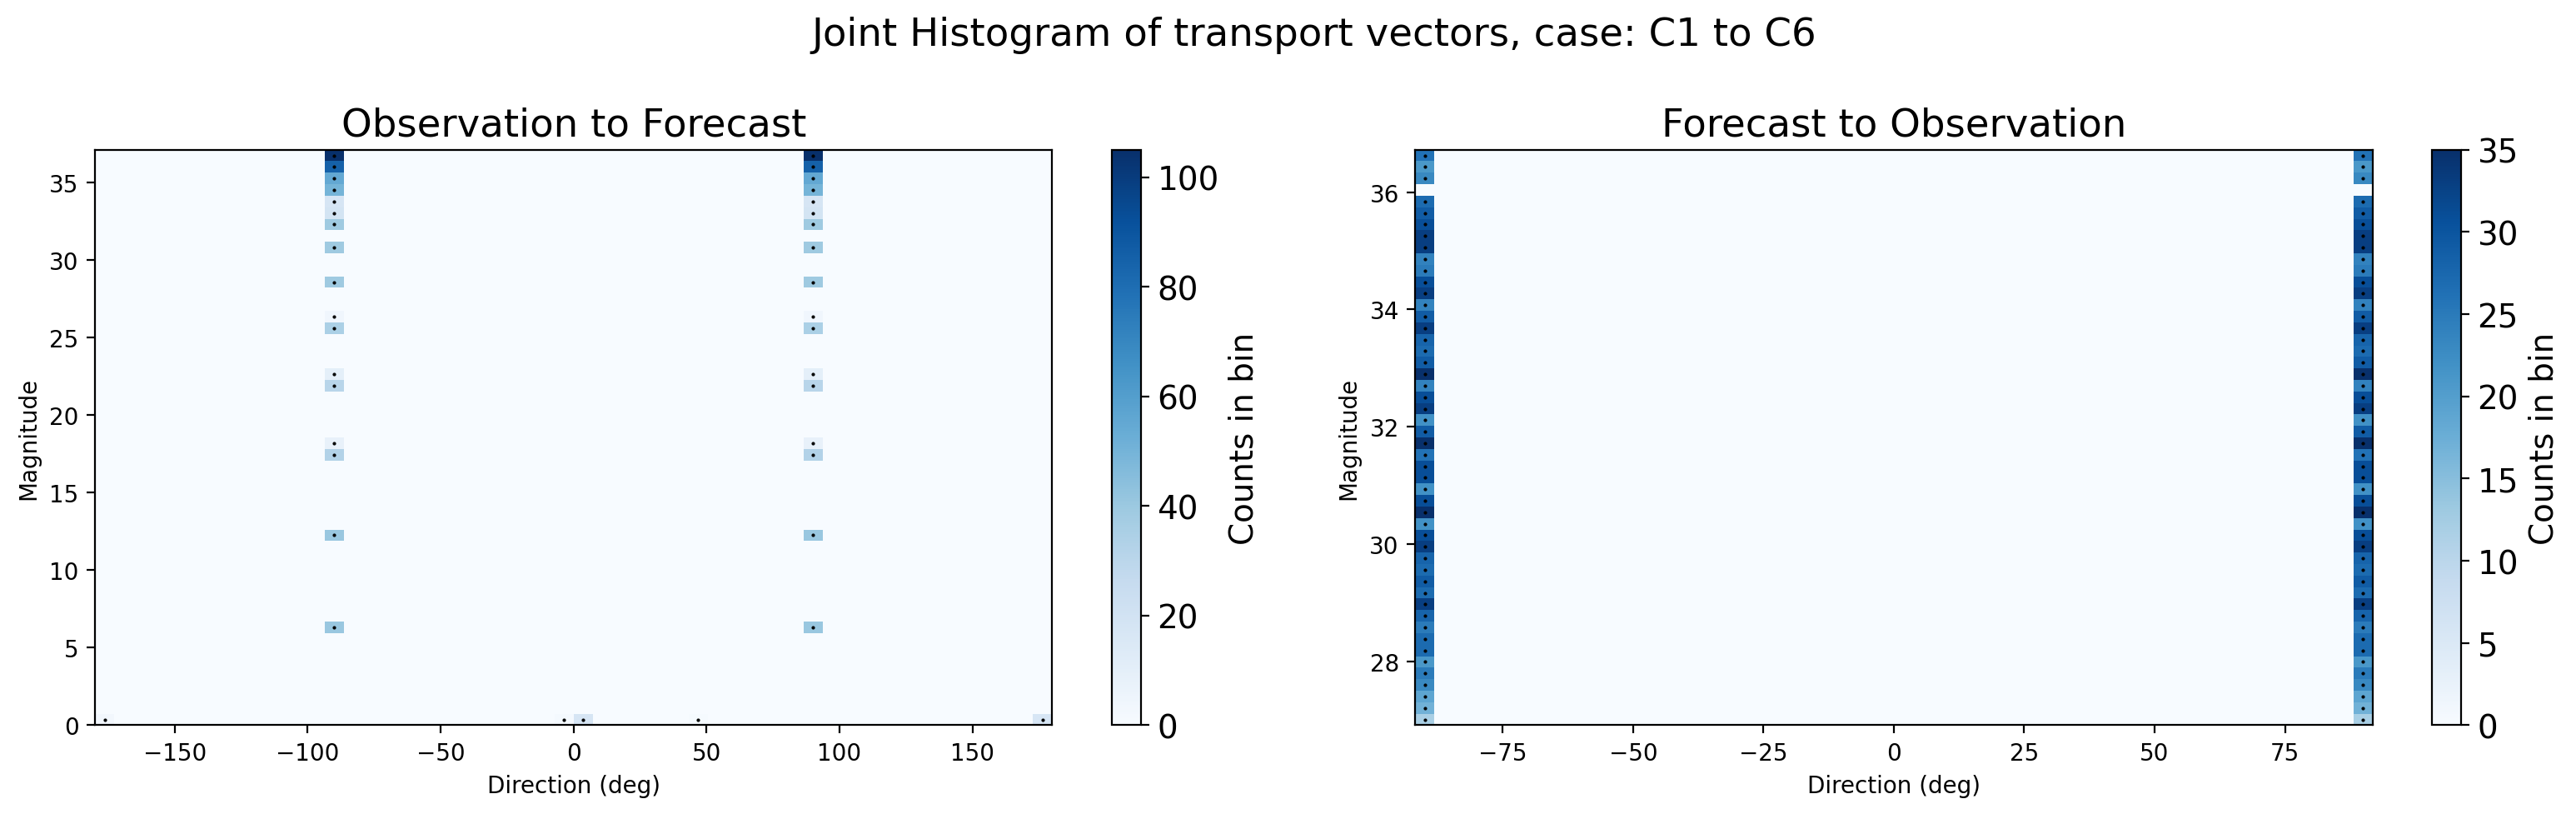

In [14]:
# Assuming v0 and u0 are already defined tensors
v0 = -(V0 - u0)
n1 = 200
mag1 = v0.norm(dim=1).numpy() * n1
direction1 = torch.rad2deg(torch.arctan2(v0[:, 1], v0[:, 0])).numpy()

# Define the second vector: v0 = -(V0 - u0)
v0_bias = -(V1 - u1)
mag2 = v0_bias.norm(dim=1).numpy() * n1
direction2 = torch.rad2deg(torch.arctan2(v0_bias[:, 1], v0_bias[:, 0])).numpy()

# Define bins (shared for both histograms)
bins = 50

# Create a single figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5), dpi=200)
plt.rcParams.update({"font.size": 14})

# Plot the first histogram (Biased)
hist1, xedges1, yedges1, img1 = axs[0].hist2d(
    direction1[~np.isnan(direction1)],
    mag1[~np.isnan(mag1)],
    bins=bins,
    cmap="Blues",
)
fig.colorbar(img1, ax=axs[0], label="Counts in bin")
axs[0].set_title("Observation to Forecast")
axs[0].set_xlabel("Direction (deg)")
axs[0].set_ylabel("Magnitude")

# Overlay black points for non-empty bins on the first plot
xcenters1 = 0.5 * (xedges1[:-1] + xedges1[1:])
ycenters1 = 0.5 * (yedges1[:-1] + yedges1[1:])
for i in range(len(xcenters1)):
    for j in range(len(ycenters1)):
        if hist1[i, j] > 0:
            axs[0].plot(
                xcenters1[i], ycenters1[j], "ko", markersize=0.5
            )  # 'ko' means black circle

# Plot the second histogram (Debiased)
hist2, xedges2, yedges2, img2 = axs[1].hist2d(
    direction2[~np.isnan(direction2)],
    mag2[~np.isnan(mag2)],
    bins=bins,
    cmap="Blues",
)
fig.colorbar(img2, ax=axs[1], label="Counts in bin")
axs[1].set_title("Forecast to Observation")
axs[1].set_xlabel("Direction (deg)")
axs[1].set_ylabel("Magnitude")

# Overlay black points for non-empty bins on the second plot
xcenters2 = 0.5 * (xedges2[:-1] + xedges2[1:])
ycenters2 = 0.5 * (yedges2[:-1] + yedges2[1:])
for i in range(len(xcenters2)):
    for j in range(len(ycenters2)):
        if hist2[i, j] > 0:
            axs[1].plot(
                xcenters2[i], ycenters2[j], "ko", markersize=0.5
            )  # 'ko' means black circle

# Optional: Add annotations or other features
# Example: Adding an arrow in the second plot
arrow_x = np.rad2deg(np.arctan2([-5], [3]))  # direction (degrees)
arrow_y = 3 / 601 + 5 / 501  # magnitude
# axs[1].annotate('Target Bin', xy=(arrow_x, arrow_y), xytext=(-50, 0.03),
#                 arrowprops=dict(facecolor='red', shrink=0.05),
#                 fontsize=12, color='red')

# Show the plots
plt.suptitle(
    "Joint Histogram of transport vectors, case: {} to {}".format(case[0], case[1])
)

plt.tight_layout()
plt.show()

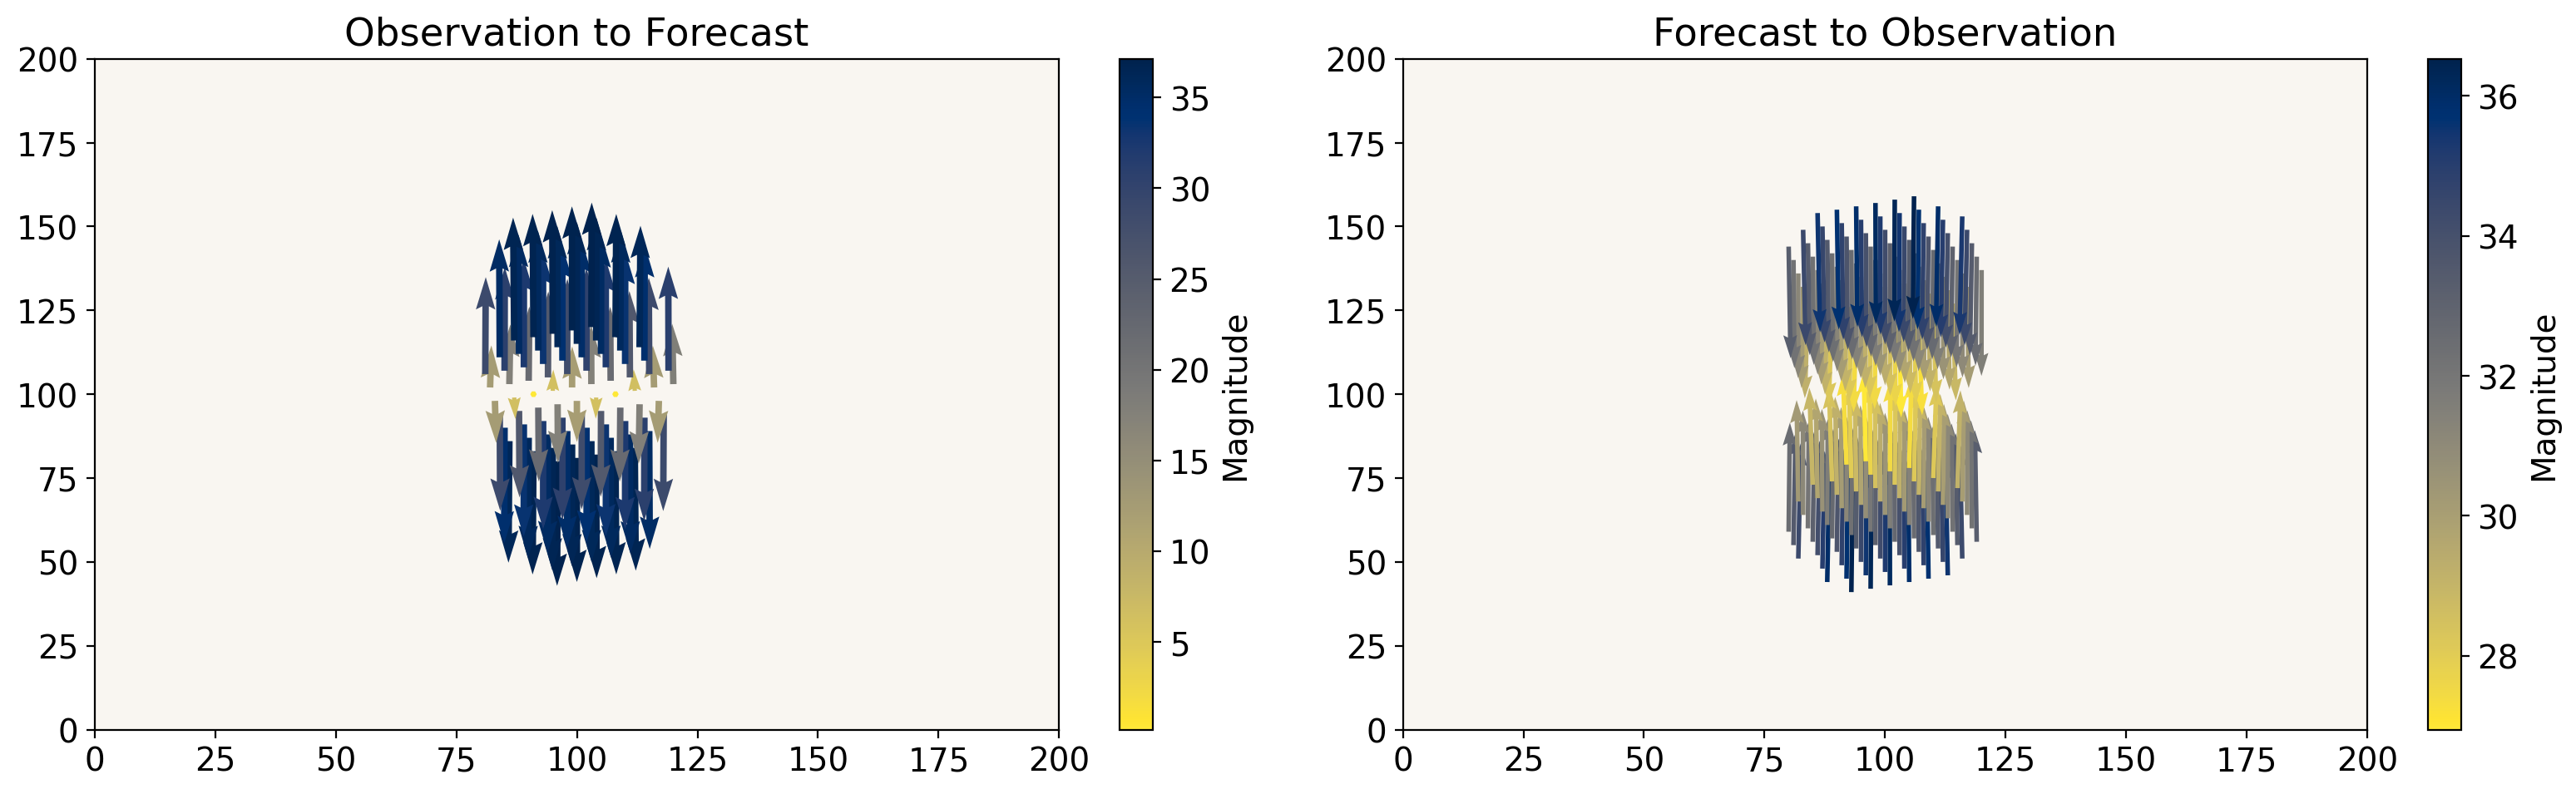

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), dpi=200)

plt.rcParams.update({"font.size": 14})

# First plot
ax = axs[0]
ax.set(xlim=(0, 200))
v0 = (V0 - u0) * 200  # Adjust vector field
step = 17
colors = torch.norm(v0[::step, :], dim=1).numpy()
colors[np.isnan(colors)] = 0
X_flat = X.reshape(-1, 2) * 200
index = colors > 0
quiv = ax.quiver(
    X_flat[::step, 0][index],
    X_flat[::step, 1][index],
    -v0[::step, 0][index],
    -v0[::step, 1][index],
    colors[index],
    cmap="cividis_r",
    angles="xy",
    scale_units="xy",
    scale=1,
)
fig.colorbar(
    quiv, ax=ax, label="Magnitude"
)  # Attach colorbar to the correct subplot
ax.set_facecolor("#f9f6f1")  # Set background color for this subplot
ax.set_title("Observation to Forecast")
ax.set(xlim=(0, 200), ylim=(0, 200))

# Second plot
ax = axs[1]
ax.set(xlim=(0, 200))
v0 = (V1 - u1) * 200  # Adjust vector field
colors = torch.norm(v0[::step, :], dim=1).numpy()
colors[np.isnan(colors)] = 0
X_flat = X.reshape(-1, 2) * 200
index = colors > 0
quiv = ax.quiver(
    X_flat[::step, 0][index],
    X_flat[::step, 1][index],
    -v0[::step, 0][index],
    -v0[::step, 1][index],
    colors[index],
    cmap="cividis_r",
    angles="xy",
    scale_units="xy",
    scale=1,
)
fig.colorbar(
    quiv, ax=ax, label="Magnitude"
)  # Attach colorbar to the correct subplot
ax.set_facecolor("#f9f6f1")  # Set background color for this subplot
ax.set_title("Forecast to Observation")

ax.set(xlim=(0, 200), ylim=(0, 200))

# plt.suptitle('C1C1 Transport Vectors', y=0.95)
plt.tight_layout()
plt.show()

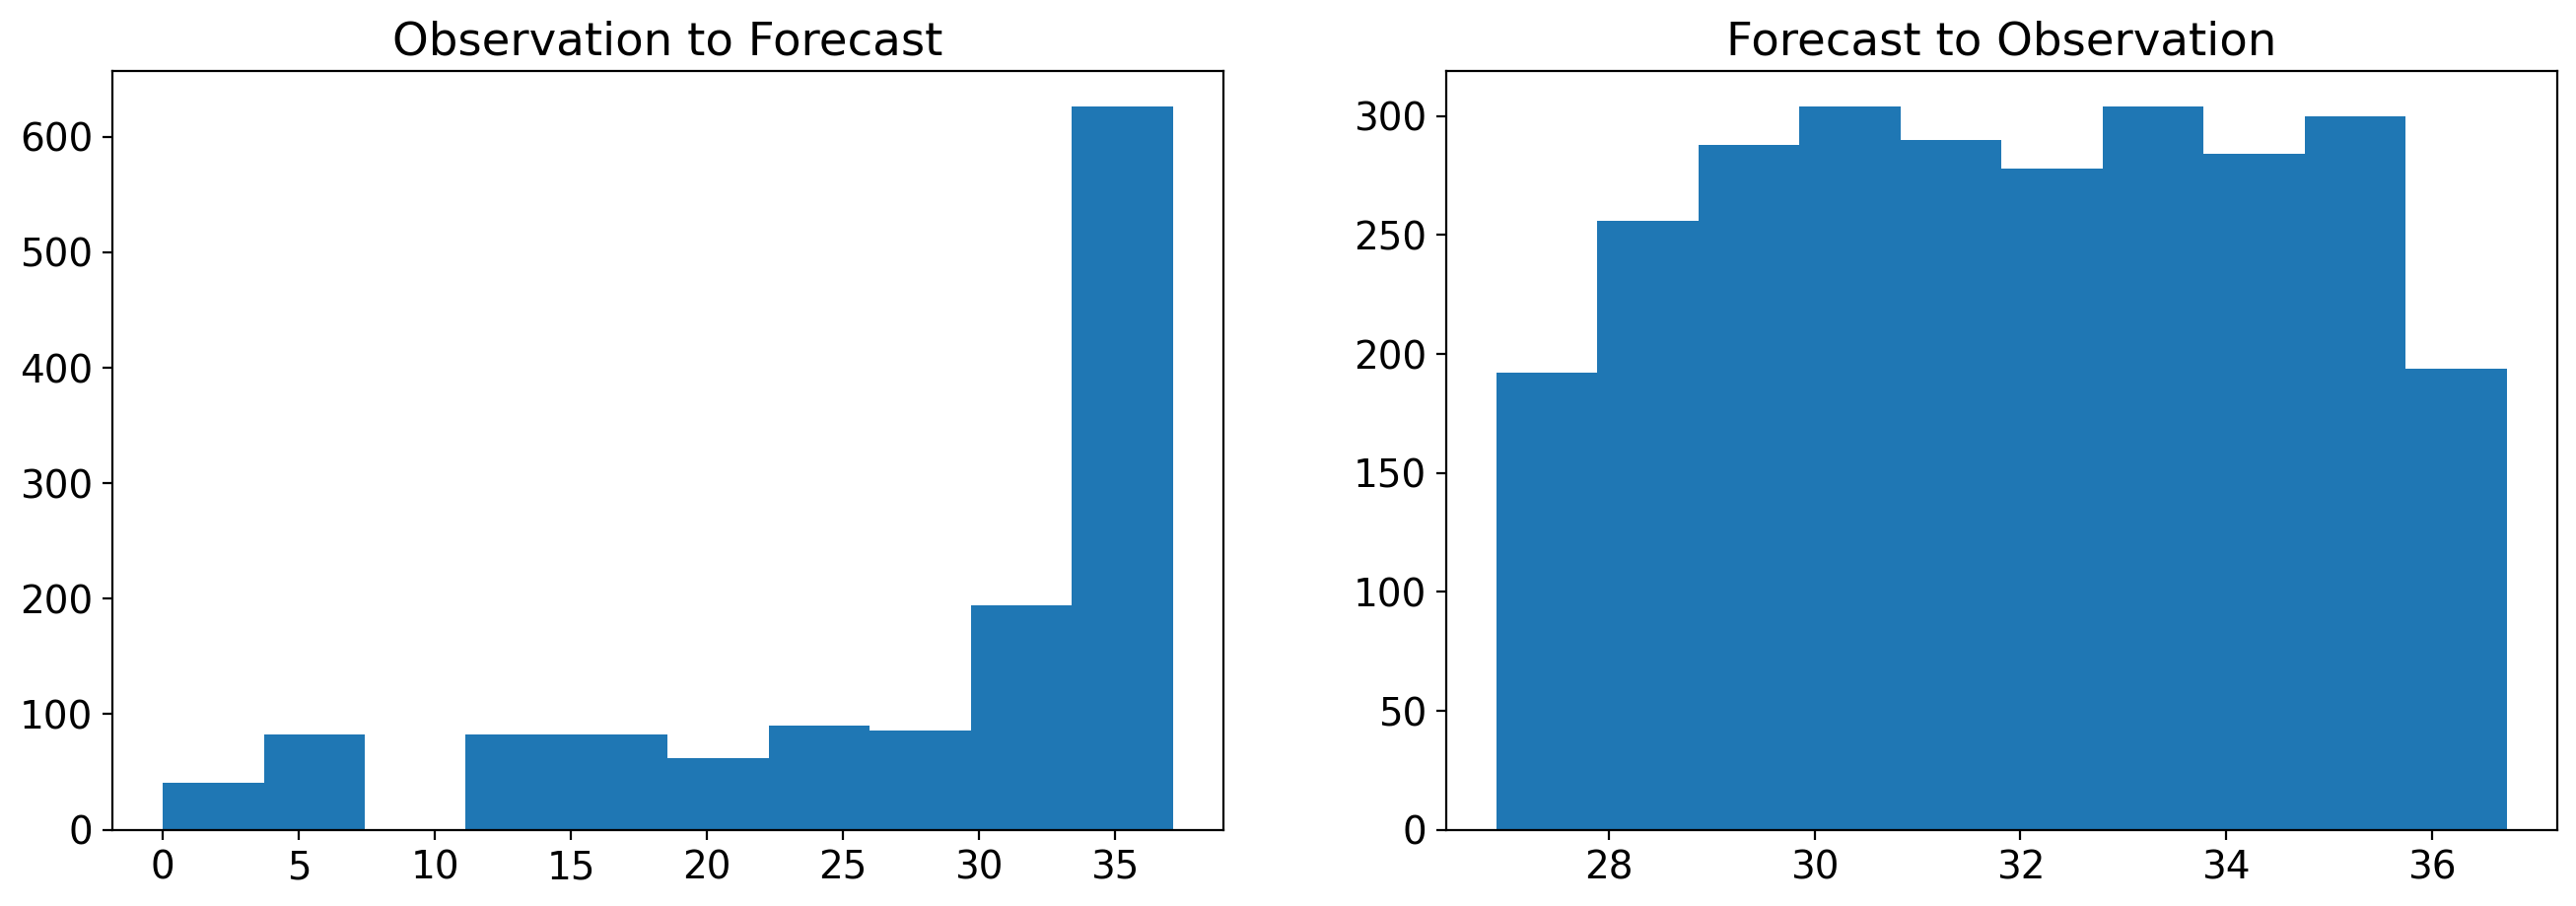

In [26]:
# histogram of magnitudee only (not direction)

fig, axs = plt.subplots(1, 2, figsize=(16, 5), dpi=200)

axs[0].set_title("Observation to Forecast")
axs[0].hist(((V0 - u0) * 200).norm(dim=-1))

axs[1].set_title("Forecast to Observation")
axs[1].hist(((V1 - u1) * 200).norm(dim=-1))
plt.show()